In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import log_loss,roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import pickle
from prettytable import PrettyTable
from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Reading Data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Applied AI/CS1/in-vehicle-coupon-recommendation.csv')
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [4]:
print("Number of data points:", data.shape[0])
print("Number of features:", data.shape[1])
print('-'*100)
print("The attributes of data :", data.columns.values)

Number of data points: 12684
Number of features: 26
----------------------------------------------------------------------------------------------------
The attributes of data : ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'car' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ5min'
 'toCoupon_GEQ15min' 'toCoupon_GEQ25min' 'direction_same' 'direction_opp'
 'Y']


In [5]:
Y_value_counts = data.groupby('Y').Y.count()
print('The number of users that are accepted the coupon is ',Y_value_counts[1],',',round(Y_value_counts[1]/data.shape[0]*100,3),'%')
print('The number of users that are rejected the coupon is ',Y_value_counts[0],',',round(Y_value_counts[0]/data.shape[0]*100,3),'%')

The number of users that are accepted the coupon is  7210 , 56.843 %
The number of users that are rejected the coupon is  5474 , 43.157 %


## 1.2 Train Test Split

In [6]:
X = data.drop(['Y'], axis=1)
y = data['Y'].values

In [7]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [8]:
# ##save results to disk
# pickle.dump((X_train, y_train),open('/content/drive/MyDrive/Applied AI/CS1/train_data.pkl','wb'))
# pickle.dump((X_test, y_test),open('/content/drive/MyDrive/Applied AI/CS1/test_data.pkl','wb'))

In [9]:
# load from disk
# X_train, y_train = pickle.load(open("/content/drive/MyDrive/Applied AI/CS1/train_data.pkl", 'rb')) 
# X_test, y_test = pickle.load(open("/content/drive/MyDrive/Applied AI/CS1/test_data.pkl", 'rb')) 

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10147, 25) (10147,)
(2537, 25) (2537,)


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10147 entries, 12406 to 9851
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           10147 non-null  object
 1   passanger             10147 non-null  object
 2   weather               10147 non-null  object
 3   temperature           10147 non-null  int64 
 4   time                  10147 non-null  object
 5   coupon                10147 non-null  object
 6   expiration            10147 non-null  object
 7   gender                10147 non-null  object
 8   age                   10147 non-null  object
 9   maritalStatus         10147 non-null  object
 10  has_children          10147 non-null  int64 
 11  education             10147 non-null  object
 12  occupation            10147 non-null  object
 13  income                10147 non-null  object
 14  car                   94 non-null     object
 15  Bar                   10057 non-n

## 1.3 Data Cleaning

In [11]:
# # Remove duplicates
# duplicate = data[data.duplicated(keep = 'last')]
# # duplicate.shape #(74, 26)
# data = data.drop_duplicates()
# print(data.shape)

__Missing Values__

In [12]:
# missing values
print('Is there any missing value present or not?',data.isnull().values.any())
missing_percentage = data.isnull().sum()*100/len(data)
missing_value_df = pd.DataFrame({'missing_count': data.isnull().sum(),'missing_percentage': missing_percentage})
missing_value_df[missing_value_df.missing_count != 0]

Is there any missing value present or not? True


,missing_count,missing_percentage
car,12576,99.148534
Bar,107,0.843582
CoffeeHouse,217,1.710817
CarryAway,151,1.190476
RestaurantLessThan20,130,1.024913
Restaurant20To50,189,1.490066


* Feature 'car' has 99% of the missing value, drop this feature because even after predicting missing values, this feature has less importance, and it has less predictive power.

In [13]:
X_train = X_train.drop(['car'], axis=1)
X_test = X_test.drop(['car'], axis=1)

__Correlation of Features__

In [14]:
X_train.corr() #covariance matrix 

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
temperature,1.000000,-0.018969,NaN,-0.154439,-0.218715,0.094829,-0.094829
has_children,-0.018969,1.000000,NaN,0.075395,-0.011417,-0.033238,0.033238
toCoupon_GEQ5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toCoupon_GEQ15min,-0.154439,0.075395,NaN,1.000000,0.326269,-0.306133,0.306133
toCoupon_GEQ25min,-0.218715,-0.011417,NaN,0.326269,1.000000,-0.191316,0.191316
direction_same,0.094829,-0.033238,NaN,-0.306133,-0.191316,1.000000,-1.000000
direction_opp,-0.094829,0.033238,NaN,0.306133,0.191316,-1.000000,1.000000


1. Feature ‘direction_same’ is perfectly correlated with ‘direction_opp’, both have the same variance.
2. ‘toCoupon_GEQ5min’ feature has no correlation with any feature because it has the same value ‘1’ for all data points, which means all the restaurants/bars are at least more than five minutes away from the driver.

so, drop both 'direction_opp' and 'toCoupon_GEQ5min' features.

In [15]:
X_train = X_train.drop(['direction_opp','toCoupon_GEQ5min'], axis=1)
X_test = X_test.drop(['direction_opp','toCoupon_GEQ5min'], axis=1)
X_train.shape, X_test.shape

((10147, 22), (2537, 22))

In [16]:
X_train.describe()
# X_train.describe(include='all')

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same
count,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000
mean,63.433527,0.411452,0.560757,0.119641,0.212181
std,19.109837,0.492121,0.496319,0.324558,0.408872
min,30.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,0.000000,0.000000,0.000000
50%,80.000000,0.000000,1.000000,0.000000,0.000000
75%,80.000000,1.000000,1.000000,0.000000,0.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000


## 1.4 Mode Imputation

In [17]:
print('Is there any missing value present or not?',X_train.isnull().values.any())

Is there any missing value present or not? True


In [18]:
# mode imputation for missing values in train data
X_train['Bar'] = X_train['Bar'].fillna(X_train['Bar'].value_counts().index[0])
X_train['CoffeeHouse'] = X_train['CoffeeHouse'].fillna(X_train['CoffeeHouse'].value_counts().index[0])
X_train['CarryAway'] = X_train['CarryAway'].fillna(X_train['CarryAway'].value_counts().index[0])
X_train['RestaurantLessThan20'] = X_train['RestaurantLessThan20'].fillna(X_train['RestaurantLessThan20'].value_counts().index[0])
X_train['Restaurant20To50'] = X_train['Restaurant20To50'].fillna(X_train['Restaurant20To50'].value_counts().index[0])

In [19]:
# mode imputation for missing values in test data
X_test['Bar'] = X_test['Bar'].fillna(X_train['Bar'].value_counts().index[0])
X_test['CoffeeHouse'] = X_test['CoffeeHouse'].fillna(X_train['CoffeeHouse'].value_counts().index[0])
X_test['CarryAway'] = X_test['CarryAway'].fillna(X_train['CarryAway'].value_counts().index[0])
X_test['RestaurantLessThan20'] = X_test['RestaurantLessThan20'].fillna(X_train['RestaurantLessThan20'].value_counts().index[0])
X_test['Restaurant20To50'] = X_test['Restaurant20To50'].fillna(X_train['Restaurant20To50'].value_counts().index[0])

In [20]:
print('Is there any missing value present in X_train?',X_train.isnull().values.any())

Is there any missing value present in X_train? False


In [21]:
print('Is there any missing value present in X_test?',X_test.isnull().values.any())

Is there any missing value present in X_test? False


## 1.5 Feature Engineering

**FE** -- __to_Coupon__

In [22]:
# FE -- to_Coupon is combination of two features, toCoupon_GEQ15min and toCoupon_GEQ25min
to_Coupon = []
for i in range(X_train.shape[0]):
    if (list(X_train['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(X_train['toCoupon_GEQ15min'])[i] == 1)and(list(X_train['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
X_train['to_Coupon'] = to_Coupon
print('Unique values:',X_train['to_Coupon'].unique())
print('-'*50)
X_train['to_Coupon'].describe()

Unique values: [0 1 2]
--------------------------------------------------


count    10147.000000
mean         0.680398
std          0.675858
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: to_Coupon, dtype: float64

In [23]:
# FE -- to_Coupon is combination of two features, toCoupon_GEQ15min and toCoupon_GEQ25min
to_Coupon = []
for i in range(X_test.shape[0]):
    if (list(X_test['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(X_test['toCoupon_GEQ15min'])[i] == 1)and(list(X_test['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
X_test['to_Coupon'] = to_Coupon
print('Unique values:',X_test['to_Coupon'].unique())
print('-'*50)
X_test['to_Coupon'].describe()

Unique values: [2 1 0]
--------------------------------------------------


count    2537.000000
mean        0.681514
std         0.671837
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: to_Coupon, dtype: float64

**FE** -- __coupon_freq__

In [24]:
# FE -- coupon_freq is combination of five features, RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, Restaurant20To50
coupon_freq = []
for i in range(X_train.shape[0]):
    if (list(X_train['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(X_train['RestaurantLessThan20'])[i])
    elif (list(X_train['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(X_train['CoffeeHouse'])[i])
    elif (list(X_train['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(X_train['CarryAway'])[i])
    elif (list(X_train['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(X_train['Bar'])[i])
    elif (list(X_train['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(X_train['Restaurant20To50'])[i])
        
X_train['coupon_freq'] = coupon_freq
print('Unique values:',X_train['coupon_freq'].unique())
print('-'*50)
X_train['coupon_freq'].describe()

Unique values: ['1~3' 'never' 'less1' '4~8' 'gt8']
--------------------------------------------------


count     10147
unique        5
top         1~3
freq       3162
Name: coupon_freq, dtype: object

In [25]:
# FE -- coupon_freq is combination of five features, RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, Restaurant20To50
coupon_freq = []
for i in range(X_test.shape[0]):
    if (list(X_test['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(X_test['RestaurantLessThan20'])[i])
    elif (list(X_test['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(X_test['CoffeeHouse'])[i])
    elif (list(X_test['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(X_test['CarryAway'])[i])
    elif (list(X_test['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(X_test['Bar'])[i])
    elif (list(X_test['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(X_test['Restaurant20To50'])[i])
        
X_test['coupon_freq'] = coupon_freq
print('Unique values:',X_test['coupon_freq'].unique()) 
print('-'*50)
X_test['coupon_freq'].describe()

Unique values: ['never' '1~3' 'less1' '4~8' 'gt8']
--------------------------------------------------


count     2537
unique       5
top        1~3
freq       730
Name: coupon_freq, dtype: object

**FE** -- __occupation_class__

In [26]:
X_train['occupation'].describe()

count          10147
unique            25
top       Unemployed
freq            1513
Name: occupation, dtype: object

In [27]:
# occupation feature has 25 no of distinct values, which creates very sparsity in data after Encoding
# FE -- occupation_class where categorize all occupation in its suitable class.
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# occupation_dict
X_train['occupation_class'] = X_train['occupation'].map(occupation_dict)
print('Unique values:',X_train['occupation_class'].unique())
print('-'*50)
X_train['occupation_class'].describe()
# X_train['occupation_class'].value_counts()

Unique values: ['Low_Acceptance' 'Medium_Acceptance' 'Medium_Low_Acceptance'
 'Medium_High_Acceptance' 'High_Acceptance']
--------------------------------------------------


count                     10147
unique                        5
top       Medium_Low_Acceptance
freq                       2662
Name: occupation_class, dtype: object

In [28]:
X_test['occupation'].describe()

count           2537
unique            25
top       Unemployed
freq             357
Name: occupation, dtype: object

In [29]:
# occupation feature has 25 no of distinct values, which creates very sparsity in data after Encoding
# FE -- occupation_class where categorize all occupation in its suitable class.
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# occupation_dict
X_test['occupation_class'] = X_test['occupation'].map(occupation_dict)
print('Unique values:',X_test['occupation_class'].unique())
print('-'*50)
X_test['occupation_class'].describe()
# X_test['occupation_class'].value_counts()

Unique values: ['Medium_Acceptance' 'Low_Acceptance' 'Medium_Low_Acceptance'
 'Medium_High_Acceptance' 'High_Acceptance']
--------------------------------------------------


count                  2537
unique                    5
top       Medium_Acceptance
freq                    675
Name: occupation_class, dtype: object

In [30]:
# After Feature Engineering, removing unwanted features
# X_train = X_train.drop(['toCoupon_GEQ15min','toCoupon_GEQ25min','Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50','occupation'], axis=1)
# X_test = X_test.drop(['toCoupon_GEQ15min','toCoupon_GEQ25min','Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50','occupation'], axis=1)
X_train = X_train.drop(['occupation'], axis=1)
X_test = X_test.drop(['occupation'], axis=1)
print('X_train:',X_train.shape,'\nX_test:',X_test.shape)
print('-'*50)
print(X_train.columns.values)

X_train: (10147, 24) 
X_test: (2537, 24)
--------------------------------------------------
['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'income' 'Bar' 'CoffeeHouse' 'CarryAway' 'RestaurantLessThan20'
 'Restaurant20To50' 'toCoupon_GEQ15min' 'toCoupon_GEQ25min'
 'direction_same' 'to_Coupon' 'coupon_freq' 'occupation_class']


## 1.6 Encoding

### 1.6.1 Ordinal Encoding

In [31]:
order = [['Work','Home','No Urgent Place'],['Kid(s)','Alone','Partner','Friend(s)'],['Rainy','Snowy','Sunny'],[30,55,80],['7AM','10AM','2PM','6PM','10PM'],
         ['Bar','Restaurant(20-50)','Coffee House','Restaurant(<20)','Carry out & Take away'],['2h','1d'],['Female','Male'],['below21','21','26','31','36','41','46','50plus'],
         ['Widowed','Divorced','Married partner','Unmarried partner','Single'],[0,1],
         ['Some High School','High School Graduate','Some college - no degree','Associates degree','Bachelors degree','Graduate degree (Masters or Doctorate)'],
         ['Less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499','$62500 - $74999','$75000 - $87499','$87500 - $99999','$100000 or More'],
         ['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],
         [0,1],[0,1],[0,1],[0,1,2],['never','less1','1~3','4~8','gt8'],['Low_Acceptance','Medium_Low_Acceptance','Medium_Acceptance','Medium_High_Acceptance','High_Acceptance']]

In [32]:
Ordinal_enc = OrdinalEncoder(categories=order)
X_train_Ordinal_encoding = Ordinal_enc.fit_transform(X_train)
X_train_Ordinal_encoding = pd.DataFrame(X_train_Ordinal_encoding,columns=X_train.columns.values)
print('X_train_Ordinal_encoding:',X_train_Ordinal_encoding.shape)

X_train_Ordinal_encoding: (10147, 24)


In [33]:
Ordinal_enc = OrdinalEncoder(categories=order)
X_test_Ordinal_encoding = Ordinal_enc.fit_transform(X_test)
X_test_Ordinal_encoding = pd.DataFrame(X_test_Ordinal_encoding,columns=X_test.columns.values)
print('X_test_Ordinal_encoding:',X_test_Ordinal_encoding.shape)

X_test_Ordinal_encoding: (2537, 24)


### 1.6.2 Frequency Encoding

In [34]:
def frequency_enc(column_name,X):
  """It returns Frequency encoded feature"""
  return X[column_name].map(X.groupby(column_name).size()/len(X))

In [35]:
X_train_frequency_encoding = pd.DataFrame()
for i in range(X_train.shape[1]):
  X_train_frequency_encoding[X_train.columns.values[i]+'_freq_enc'] = frequency_enc(X_train.columns.values[i],X_train)

print('X_train_frequency_encoding:',X_train_frequency_encoding.shape)

X_train_frequency_encoding: (10147, 24)


In [36]:
X_test_frequency_encoding = pd.DataFrame()
for i in range(X_test.shape[1]):
  X_test_frequency_encoding[X_test.columns.values[i]+'_freq_enc'] = frequency_enc(X_test.columns.values[i],X_test)

print('X_test_frequency_encoding:',X_test_frequency_encoding.shape)

X_test_frequency_encoding: (2537, 24)


### 1.6.3 Target Encoding

In [37]:
def target_enc(column_name,X):
  """It returns Target encoded feature for train data"""
  X['Y_train'] = y_train
  return X[column_name].map(X.groupby(column_name)['Y_train'].mean())

X_train_target_encoding = pd.DataFrame()
for i in range(X_train.shape[1]):
  X_train_target_encoding[X_train.columns.values[i]+'_target_enc'] = target_enc(X_train.columns.values[i],X_train)

print('X_train_target_encoding:',X_train_target_encoding.shape)

X_train_target_encoding: (10147, 24)


In [38]:
def target_enc(column_name,X):
  """It returns Target encoded feature for test data"""
  X['Y_test'] = y_test
  return X[column_name].map(X.groupby(column_name)['Y_test'].mean())

X_test_target_encoding = pd.DataFrame()
for i in range(X_test.shape[1]):
  X_test_target_encoding[X_test.columns.values[i]+'_target_enc'] = target_enc(X_test.columns.values[i],X_test)

print('X_test_target_encoding:',X_test_target_encoding.shape)

X_test_target_encoding: (2537, 24)


### 1.6.4 Response Encoding

In [39]:
# response encoding function
def response_coding(feature,X,Y):
    """It returns Response encoded feature"""
    X[feature] = X[feature].str.replace('~','_')
    X[feature] = X[feature].str.replace('[^a-zA-Z0-9_ ]',' ')
    X[feature] = X[feature].str.replace(' +',' ')
    X[feature] = X[feature].str.strip()
    X[feature] = X[feature].str.replace(' ','_')
    X[feature] = X[feature].str.lower()
    response_code_0 = [];response_code_1 = []
    unique_cat_features = X[feature].unique()
    unique_cat_features = np.sort(unique_cat_features)
    for i in range(len(unique_cat_features)):
        total_count = X[feature][(X[feature] == unique_cat_features[i])].count()
        p0 = (X[feature][((X[feature] == unique_cat_features[i]) & (Y==0))].count())/total_count
        p1 = (X[feature][((X[feature] == unique_cat_features[i]) & (Y==1))].count())/total_count
        response_code_0.append(p0);response_code_1.append(p1)
    dict_response_code_0 = dict(zip(unique_cat_features, response_code_0))
    dict_response_code_1 = dict(zip(unique_cat_features, response_code_1))
    X_response_0 = X[feature].map(dict_response_code_0)
    X_response_1 = X[feature].map(dict_response_code_1)
    X_response_0 = X_response_0.values.reshape(-1,1)
    X_response_1 = X_response_1.values.reshape(-1,1)
    return X_response_0,X_response_1

In [40]:
X_train_destination_0,X_train_destination_1 = response_coding('destination',X_train,y_train)
X_train_passanger_0,X_train_passanger_1 = response_coding('passanger',X_train,y_train)
X_train_weather_0,X_train_weather_1 = response_coding('weather',X_train,y_train)
X_train_time_0,X_train_time_1 = response_coding('time',X_train,y_train)
X_train_coupon_0,X_train_coupon_1 = response_coding('coupon',X_train,y_train)
X_train_expiration_0,X_train_expiration_1 = response_coding('expiration',X_train,y_train)
X_train_gender_0,X_train_gender_1 = response_coding('gender',X_train,y_train)
X_train_age_0,X_train_age_1 = response_coding('age',X_train,y_train)
X_train_maritalStatus_0,X_train_maritalStatus_1 = response_coding('maritalStatus',X_train,y_train)
X_train_education_0,X_train_education_1 = response_coding('education',X_train,y_train)
X_train_income_0,X_train_income_1 = response_coding('income',X_train,y_train)
X_train_Bar_0,X_train_Bar_1 = response_coding('Bar',X_train,y_train)
X_train_CoffeeHouse_0,X_train_CoffeeHouse_1 = response_coding('CoffeeHouse',X_train,y_train)
X_train_CarryAway_0,X_train_CarryAway_1 = response_coding('CarryAway',X_train,y_train)
X_train_RestaurantLessThan20_0,X_train_RestaurantLessThan20_1 = response_coding('RestaurantLessThan20',X_train,y_train)
X_train_Restaurant20To50_0,X_train_Restaurant20To50_1 = response_coding('Restaurant20To50',X_train,y_train)
X_train_coupon_freq_0,X_train_coupon_freq_1 = response_coding('coupon_freq',X_train,y_train)
X_train_occupation_class_0,X_train_occupation_class_1 = response_coding('occupation_class',X_train,y_train)

X_test_destination_0,X_test_destination_1 = response_coding('destination',X_test,y_test)
X_test_passanger_0,X_test_passanger_1 = response_coding('passanger',X_test,y_test)
X_test_weather_0,X_test_weather_1 = response_coding('weather',X_test,y_test)
X_test_time_0,X_test_time_1 = response_coding('time',X_test,y_test)
X_test_coupon_0,X_test_coupon_1 = response_coding('coupon',X_test,y_test)
X_test_expiration_0,X_test_expiration_1 = response_coding('expiration',X_test,y_test)
X_test_gender_0,X_test_gender_1 = response_coding('gender',X_test,y_test)
X_test_age_0,X_test_age_1 = response_coding('age',X_test,y_test)
X_test_maritalStatus_0,X_test_maritalStatus_1 = response_coding('maritalStatus',X_test,y_test)
X_test_education_0,X_test_education_1 = response_coding('education',X_test,y_test)
X_test_income_0,X_test_income_1 = response_coding('income',X_test,y_test)
X_test_Bar_0,X_test_Bar_1 = response_coding('Bar',X_test,y_test)
X_test_CoffeeHouse_0,X_test_CoffeeHouse_1 = response_coding('CoffeeHouse',X_test,y_test)
X_test_CarryAway_0,X_test_CarryAway_1 = response_coding('CarryAway',X_test,y_test)
X_test_RestaurantLessThan20_0,X_test_RestaurantLessThan20_1 = response_coding('RestaurantLessThan20',X_test,y_test)
X_test_Restaurant20To50_0,X_test_Restaurant20To50_1 = response_coding('Restaurant20To50',X_test,y_test)
X_test_coupon_freq_0,X_test_coupon_freq_1 = response_coding('coupon_freq',X_test,y_test)
X_test_occupation_class_0,X_test_occupation_class_1 = response_coding('occupation_class',X_test,y_test)

In [41]:
# Normalization of numerical features
def norm(column_name,X):
    """It returns Normalized feature"""
    normalizer = Normalizer()
    normalizer.fit(X[column_name].values.reshape(1,-1))
    X_norm = normalizer.transform(X[column_name].values.reshape(1,-1))
    return X_norm.reshape(-1,1)

In [42]:
X_train_temperature_norm = norm('temperature',X_train)
X_train_has_children_norm = norm('has_children',X_train)
X_train_toCoupon_GEQ15min_norm = norm('toCoupon_GEQ15min',X_train)
X_train_toCoupon_GEQ25min_norm = norm('toCoupon_GEQ25min',X_train)
X_train_direction_same_norm = norm('direction_same',X_train)
X_train_to_Coupon_norm = norm('to_Coupon',X_train)

X_test_temperature_norm = norm('temperature',X_test)
X_test_has_children_norm = norm('has_children',X_test)
X_test_toCoupon_GEQ15min_norm = norm('toCoupon_GEQ15min',X_test)
X_test_toCoupon_GEQ25min_norm = norm('toCoupon_GEQ25min',X_test)
X_test_direction_same_norm = norm('direction_same',X_test)
X_test_to_Coupon_norm = norm('to_Coupon',X_test)

In [43]:
X_train_response_encoding = np.hstack((X_train_destination_0,X_train_destination_1,X_train_passanger_0,X_train_passanger_1,X_train_weather_0,X_train_weather_1,X_train_time_0,X_train_time_1,X_train_coupon_0,X_train_coupon_1,X_train_expiration_0,X_train_expiration_1,X_train_gender_0,X_train_gender_1,X_train_age_0,X_train_age_1,X_train_maritalStatus_0,X_train_maritalStatus_1,X_train_education_0,X_train_education_1,X_train_income_0,X_train_income_1,X_train_coupon_freq_0,X_train_coupon_freq_1,X_train_occupation_class_0,X_train_occupation_class_1,X_train_Bar_0,X_train_Bar_1,X_train_CoffeeHouse_0,X_train_CoffeeHouse_1,X_train_CarryAway_0,X_train_CarryAway_1,X_train_RestaurantLessThan20_0,X_train_RestaurantLessThan20_1,X_train_Restaurant20To50_0,X_train_Restaurant20To50_1,X_train_temperature_norm,X_train_has_children_norm,X_train_toCoupon_GEQ15min_norm,X_train_toCoupon_GEQ25min_norm,X_train_direction_same_norm,X_train_to_Coupon_norm))
X_test_response_encoding = np.hstack((X_test_destination_0,X_test_destination_1,X_test_passanger_0,X_test_passanger_1,X_test_weather_0,X_test_weather_1,X_test_time_0,X_test_time_1,X_test_coupon_0,X_test_coupon_1,X_test_expiration_0,X_test_expiration_1,X_test_gender_0,X_test_gender_1,X_test_age_0,X_test_age_1,X_test_maritalStatus_0,X_test_maritalStatus_1,X_test_education_0,X_test_education_1,X_test_income_0,X_test_income_1,X_test_coupon_freq_0,X_test_coupon_freq_1,X_test_occupation_class_0,X_test_occupation_class_1,X_test_Bar_0,X_test_Bar_1,X_test_CoffeeHouse_0,X_test_CoffeeHouse_1,X_test_CarryAway_0,X_test_CarryAway_1,X_test_RestaurantLessThan20_0,X_test_RestaurantLessThan20_1,X_test_Restaurant20To50_0,X_test_Restaurant20To50_1 ,X_test_temperature_norm,X_test_has_children_norm,X_test_toCoupon_GEQ15min_norm,X_test_toCoupon_GEQ25min_norm,X_test_direction_same_norm,X_test_to_Coupon_norm))
print('X_train_response_encoding:',X_train_response_encoding.shape,'\nX_test_response_encoding:',X_test_response_encoding.shape)

X_train_response_encoding: (10147, 42) 
X_test_response_encoding: (2537, 42)


### 1.6.5 One Hot Encoding

In [44]:
# one hot encoding function
def ohe(column_name,X):
    """It returns One hot encoded feature in X data"""  
    X[column_name] = X[column_name].str.replace('~','_')
    X[column_name] = X[column_name].str.replace('[^a-zA-Z0-9_ ]',' ')
    X[column_name] = X[column_name].str.replace(' +',' ')
    X[column_name] = X[column_name].str.strip()
    X[column_name] = X[column_name].str.replace(' ','_')
    X[column_name] = X[column_name].str.lower()
    vectorizer = CountVectorizer(binary=True)
    return vectorizer.fit_transform(X[column_name].values)

In [45]:
X_train_destination_ohe = ohe('destination',X_train)
X_train_passanger_ohe = ohe('passanger',X_train)
X_train_weather_ohe = ohe('weather',X_train)
X_train_time_ohe = ohe('time',X_train)
X_train_coupon_ohe = ohe('coupon',X_train)
X_train_expiration_ohe = ohe('expiration',X_train)
X_train_gender_ohe = ohe('gender',X_train)
X_train_age_ohe = ohe('age',X_train)
X_train_maritalStatus_ohe = ohe('maritalStatus',X_train)
X_train_education_ohe = ohe('education',X_train)
X_train_income_ohe = ohe('income',X_train)
X_train_Bar_ohe = ohe('Bar',X_train)
X_train_CoffeeHouse_ohe = ohe('CoffeeHouse',X_train)
X_train_CarryAway_ohe = ohe('CarryAway',X_train)
X_train_RestaurantLessThan20_ohe = ohe('RestaurantLessThan20',X_train)
X_train_Restaurant20To50_ohe = ohe('Restaurant20To50',X_train)
X_train_coupon_freq_ohe = ohe('coupon_freq',X_train)
X_train_occupation_class_ohe = ohe('occupation_class',X_train)

X_test_destination_ohe = ohe('destination',X_test)
X_test_passanger_ohe = ohe('passanger',X_test)
X_test_weather_ohe = ohe('weather',X_test)
X_test_time_ohe = ohe('time',X_test)
X_test_coupon_ohe = ohe('coupon',X_test)
X_test_expiration_ohe = ohe('expiration',X_test)
X_test_gender_ohe = ohe('gender',X_test)
X_test_age_ohe = ohe('age',X_test)
X_test_maritalStatus_ohe = ohe('maritalStatus',X_test)
X_test_education_ohe = ohe('education',X_test)
X_test_income_ohe = ohe('income',X_test)
X_test_Bar_ohe = ohe('Bar',X_test)
X_test_CoffeeHouse_ohe = ohe('CoffeeHouse',X_test)
X_test_CarryAway_ohe = ohe('CarryAway',X_test)
X_test_RestaurantLessThan20_ohe = ohe('RestaurantLessThan20',X_test)
X_test_Restaurant20To50_ohe = ohe('Restaurant20To50',X_test)
X_test_coupon_freq_ohe = ohe('coupon_freq',X_test)
X_test_occupation_class_ohe = ohe('occupation_class',X_test)

In [46]:
# Normalization of numerical features
def norm(column_name,X):
    """It returns Normalized feature"""
    normalizer = Normalizer()
    normalizer.fit(X[column_name].values.reshape(1,-1))
    X_norm = normalizer.transform(X[column_name].values.reshape(1,-1))
    return X_norm.reshape(-1,1)

In [47]:
X_train_temperature_norm = norm('temperature',X_train)
X_train_has_children_norm = norm('has_children',X_train)
X_train_toCoupon_GEQ15min_norm = norm('toCoupon_GEQ15min',X_train)
X_train_toCoupon_GEQ25min_norm = norm('toCoupon_GEQ25min',X_train)
X_train_direction_same_norm = norm('direction_same',X_train)
X_train_to_Coupon_norm = norm('to_Coupon',X_train)

X_test_temperature_norm = norm('temperature',X_test)
X_test_has_children_norm = norm('has_children',X_test)
X_test_toCoupon_GEQ15min_norm = norm('toCoupon_GEQ15min',X_test)
X_test_toCoupon_GEQ25min_norm = norm('toCoupon_GEQ25min',X_test)
X_test_direction_same_norm = norm('direction_same',X_test)
X_test_to_Coupon_norm = norm('to_Coupon',X_test)

In [48]:
from scipy.sparse import hstack
X_train_ohe = hstack((X_train_destination_ohe, X_train_passanger_ohe, X_train_weather_ohe, X_train_time_ohe, X_train_coupon_ohe, X_train_expiration_ohe, X_train_gender_ohe, X_train_age_ohe, X_train_maritalStatus_ohe, X_train_education_ohe, X_train_income_ohe, X_train_coupon_freq_ohe, X_train_occupation_class_ohe,X_train_Bar_ohe,X_train_CoffeeHouse_ohe,X_train_CarryAway_ohe,X_train_RestaurantLessThan20_ohe,X_train_Restaurant20To50_ohe,X_train_temperature_norm, X_train_has_children_norm,X_train_toCoupon_GEQ15min_norm,X_train_toCoupon_GEQ25min_norm,X_train_direction_same_norm,X_train_to_Coupon_norm)).tocsr()
X_test_ohe = hstack((X_test_destination_ohe, X_test_passanger_ohe, X_test_weather_ohe, X_test_time_ohe, X_test_coupon_ohe, X_test_expiration_ohe, X_test_gender_ohe, X_test_age_ohe, X_test_maritalStatus_ohe, X_test_education_ohe, X_test_income_ohe, X_test_coupon_freq_ohe, X_test_occupation_class_ohe,X_test_Bar_ohe,X_test_CoffeeHouse_ohe,X_test_CarryAway_ohe,X_test_RestaurantLessThan20_ohe,X_test_Restaurant20To50_ohe,X_test_temperature_norm, X_test_has_children_norm,X_test_toCoupon_GEQ15min_norm,X_test_toCoupon_GEQ25min_norm,X_test_direction_same_norm,X_test_to_Coupon_norm)).tocsr()
print('X_train_ohe:',X_train_ohe.shape,'\nX_test_ohe:',X_test_ohe.shape)

X_train_ohe: (10147, 93) 
X_test_ohe: (2537, 93)


## 1.7 Modeling

### 1.7.1 Random Model

In [49]:
y_pred_test = []
for i in range(len(y_test)):
    r = np.random.random()
    if r<0.5:
        y_pred_test.append(0)
    else:
        y_pred_test.append(1)

print("log_loss on Test Data using Random Model is",log_loss(y_test,y_pred_test))
print("roc_auc_score on Test Data using Random Model is",roc_auc_score(y_test,y_pred_test))

log_loss on Test Data using Random Model is 17.289980056501275
roc_auc_score on Test Data using Random Model is 0.5000842310590947


### 1.7.2 Logistic Regression

In [50]:
def Logistic_Regression(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Logistic Regression Model"""

  clf = LogisticRegression(random_state=0,C=1.0)
  parameters = {'C':[0.01, 0.1, 1, 10, 100, 500]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_C = model.best_params_['C']

  clf = LogisticRegression(random_state=0,C=best_C).fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_C,Train_loss,Train_AUC,Test_loss,Test_AUC

In [51]:
# Ordinal Encoding
best_C_OrEnc, Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = Logistic_Regression(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_C_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Logistic_Regression(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_C_TarEnc, Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = Logistic_Regression(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_C_ResEnc, Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = Logistic_Regression(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_C_ohe, Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = Logistic_Regression(X_train_ohe,y_train,X_test_ohe,y_test)

In [52]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Logistic Regression","Ordinal Encoding",best_C_OrEnc,'',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Logistic Regression","Frequency Encoding",best_C_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Logistic Regression","Target Encoding",best_C_TarEnc,'',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Logistic Regression","Response Encoding",best_C_ResEnc,'',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Logistic Regression","One Hot Encoding",best_C_ohe,'',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Logistic_Regression_Result = table[0]
Logistic_Regression_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Logistic Regression,Ordinal Encoding,100,NaN,0.580,0.754,0.582,0.755
1,Logistic Regression,Frequency Encoding,500,NaN,0.642,0.660,0.643,0.660
2,Logistic Regression,Target Encoding,500,NaN,0.569,0.765,0.570,0.765
3,Logistic Regression,Response Encoding,500,NaN,0.568,0.766,0.572,0.764
4,Logistic Regression,One Hot Encoding,500,NaN,0.559,0.776,0.571,0.764


### 1.7.3 K-Nearest Neighbor

In [53]:
def K_Neighbors_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of K-Nearest Neighbors Model"""

  clf = KNeighborsClassifier()
  parameters = {'n_neighbors':[11, 15, 21, 31, 41, 51]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_n_neighbors = model.best_params_['n_neighbors']

  clf = KNeighborsClassifier(n_neighbors=best_n_neighbors).fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_n_neighbors,Train_loss,Train_AUC,Test_loss,Test_AUC

In [54]:
# Ordinal Encoding
best_n_OrEnc, Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = K_Neighbors_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_n_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = K_Neighbors_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_n_TarEnc, Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = K_Neighbors_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_n_ResEnc, Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = K_Neighbors_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_n_ohe, Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = K_Neighbors_Classifier(X_train_ohe,y_train,X_test_ohe,y_test)

In [55]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["K-Nearest Neighbor","Ordinal Encoding",best_n_OrEnc,'',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["K-Nearest Neighbor","Frequency Encoding",best_n_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["K-Nearest Neighbor","Target Encoding",best_n_TarEnc,'',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["K-Nearest Neighbor","Response Encoding",best_n_ResEnc,'',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["K-Nearest Neighbor","One Hot Encoding",best_n_ohe,'',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
K_Nearest_Neighbor_Result = table[0]
K_Nearest_Neighbor_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,K-Nearest Neighbor,Ordinal Encoding,21,NaN,0.525,0.822,0.571,0.767
1,K-Nearest Neighbor,Frequency Encoding,21,NaN,0.587,0.754,0.635,0.676
2,K-Nearest Neighbor,Target Encoding,31,NaN,0.534,0.800,0.574,0.774
3,K-Nearest Neighbor,Response Encoding,41,NaN,0.542,0.793,0.558,0.776
4,K-Nearest Neighbor,One Hot Encoding,41,NaN,0.547,0.818,0.563,0.793


### 1.7.4 Decision Tree

In [56]:
def Decision_Tree_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Decision Trees Model"""

  clf = DecisionTreeClassifier(class_weight='balanced')
  parameters = {'max_depth':[1, 5, 10, 50], 'min_samples_split':[5, 10, 100, 500]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_depth = model.best_params_['max_depth']
  best_samples_split = model.best_params_['min_samples_split']

  clf = DecisionTreeClassifier(class_weight='balanced', max_depth=best_depth, min_samples_split=best_samples_split, random_state=0)
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_depth,best_samples_split,Train_loss,Train_AUC,Test_loss,Test_AUC

In [57]:
# Ordinal Encoding
best_depth_OrEnc,best_samples_split_OrEnc,Train_loss_OrEnc,Train_AUC_OrEnc,Test_loss_OrEnc,Test_AUC_OrEnc = Decision_Tree_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_depth_FreEnc,best_samples_split_FreEnc,Train_loss_FreEnc,Train_AUC_FreEnc,Test_loss_FreEnc,Test_AUC_FreEnc = Decision_Tree_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_depth_TarEnc,best_samples_split_TarEnc,Train_loss_TarEnc,Train_AUC_TarEnc,Test_loss_TarEnc,Test_AUC_TarEnc = Decision_Tree_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_depth_ResEnc,best_samples_split_ResEnc,Train_loss_ResEnc,Train_AUC_ResEnc,Test_loss_ResEnc,Test_AUC_ResEnc = Decision_Tree_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_depth_ohe,best_samples_split_ohe,Train_loss_ohe,Train_AUC_ohe,Test_loss_ohe,Test_AUC_ohe = Decision_Tree_Classifier(X_train_ohe,y_train,X_test_ohe,y_test)

In [58]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Decision Tree","Ordinal Encoding",best_depth_OrEnc,best_samples_split_OrEnc,round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Decision Tree","Frequency Encoding",best_depth_FreEnc,best_samples_split_FreEnc,round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Decision Tree","Target Encoding",best_depth_TarEnc,best_samples_split_TarEnc,round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Decision Tree","Response Encoding",best_depth_ResEnc,best_samples_split_ResEnc,round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Decision Tree","One Hot Encoding",best_depth_ohe,best_samples_split_ohe,round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Decision_Tree_Result = table[0]
Decision_Tree_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Decision Tree,Ordinal Encoding,50,100,0.504,0.827,0.756,0.764
1,Decision Tree,Frequency Encoding,10,100,0.523,0.811,0.712,0.732
2,Decision Tree,Target Encoding,50,100,0.506,0.825,0.852,0.740
3,Decision Tree,Response Encoding,50,100,0.506,0.825,0.891,0.736
4,Decision Tree,One Hot Encoding,10,100,0.531,0.805,0.600,0.757


### 1.7.5 Support Vector Classification with 'rbf' kernel

In [59]:
def SVC_rbf(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of SVC_rbf Model"""

  clf = SVC(C=1.0,kernel='rbf',class_weight='balanced')
  parameters = {'C':[0.1, 1, 10, 100, 500]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_C = model.best_params_['C']
  
  clf = SVC(C=best_C,kernel='rbf',class_weight='balanced',probability=True)
  clf.fit(x_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_C,Train_loss,Train_AUC,Test_loss,Test_AUC

In [60]:
# Ordinal Encoding
best_C_OrEnc, Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = SVC_rbf(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_C_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = SVC_rbf(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_C_TarEnc, Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = SVC_rbf(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_C_ResEnc, Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = SVC_rbf(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_C_ohe, Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = SVC_rbf(X_train_ohe,y_train,X_test_ohe,y_test)

In [61]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Support Vector Classification","Ordinal Encoding",best_C_OrEnc,'',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Support Vector Classification","Frequency Encoding",best_C_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Support Vector Classification","Target Encoding",best_C_TarEnc,'',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Support Vector Classification","Response Encoding",best_C_ResEnc,'',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Support Vector Classification","One Hot Encoding",best_C_ohe,'',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
SVC_rbf_Result = table[0]
SVC_rbf_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Support Vector Classification,Ordinal Encoding,10,NaN,0.437,0.888,0.525,0.811
1,Support Vector Classification,Frequency Encoding,100,NaN,0.492,0.859,0.579,0.758
2,Support Vector Classification,Target Encoding,10,NaN,0.454,0.885,0.564,0.775
3,Support Vector Classification,Response Encoding,500,NaN,0.528,0.814,0.570,0.771
4,Support Vector Classification,One Hot Encoding,1,NaN,0.402,0.909,0.504,0.828


### 1.7.6 LinearSVC

In [69]:
from sklearn.svm import LinearSVC
def Linear_SVC(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Linear_SVC Model"""

  clf = LinearSVC(C=1.0,random_state=42)
  parameters = {'C':[0.1, 1, 10, 100, 500]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_C = model.best_params_['C']
  
  clf = LinearSVC(C=best_C,random_state=42)
  clf.fit(x_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,sig_clf.predict_proba(np.array(x_train)))
  Train_AUC = roc_auc_score(y_train,(sig_clf.predict_proba(np.array(x_train)))[:,1])
  Test_loss = log_loss(y_test,sig_clf.predict_proba(np.array(x_test)))
  Test_AUC = roc_auc_score(y_test,(sig_clf.predict_proba(np.array(x_test)))[:,1])

  return best_C,Train_loss,Train_AUC,Test_loss,Test_AUC

In [72]:
# Ordinal Encoding
best_C_OrEnc, Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = Linear_SVC(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_C_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Linear_SVC(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_C_TarEnc, Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = Linear_SVC(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_C_ResEnc, Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = Linear_SVC(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_C_ohe, Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = Linear_SVC(X_train_ohe.toarray(),y_train,X_test_ohe.toarray(),y_test)

In [73]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Linear_SVC","Ordinal Encoding",best_C_OrEnc,'',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Linear_SVC","Frequency Encoding",best_C_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Linear_SVC","Target Encoding",best_C_TarEnc,'',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Linear_SVC","Response Encoding",best_C_ResEnc,'',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Linear_SVC","One Hot Encoding",best_C_ohe,'',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Linear_SVC_Result = table[0]
Linear_SVC_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Linear_SVC,Ordinal Encoding,0.1,NaN,0.581,0.754,0.582,0.755
1,Linear_SVC,Frequency Encoding,10.0,NaN,0.642,0.660,0.643,0.660
2,Linear_SVC,Target Encoding,10.0,NaN,0.567,0.767,0.570,0.765
3,Linear_SVC,Response Encoding,10.0,NaN,0.567,0.767,0.574,0.762
4,Linear_SVC,One Hot Encoding,1.0,NaN,0.559,0.776,0.565,0.771


### 1.7.7  Gaussian Naive Bayes

In [74]:
def Gaussian_NB(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Gaussian_NB Model"""

  clf = GaussianNB()
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return Train_loss,Train_AUC,Test_loss,Test_AUC

In [75]:
# Ordinal Encoding
Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = Gaussian_NB(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Gaussian_NB(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = Gaussian_NB(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = Gaussian_NB(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = Gaussian_NB(X_train_ohe.toarray(),y_train,X_test_ohe.toarray(),y_test)

In [76]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Gaussian NB","Ordinal Encoding",'','',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Gaussian NB","Frequency Encoding",'','',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Gaussian NB","Target Encoding",'','',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Gaussian NB","Response Encoding",'','',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Gaussian NB","One Hot Encoding",'','',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Gaussian_NB_Result = table[0]
Gaussian_NB_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Gaussian NB,Ordinal Encoding,NaN,NaN,0.740,0.715,0.718,0.723
1,Gaussian NB,Frequency Encoding,NaN,NaN,0.840,0.654,0.831,0.656
2,Gaussian NB,Target Encoding,NaN,NaN,0.818,0.730,0.836,0.736
3,Gaussian NB,Response Encoding,NaN,NaN,1.126,0.740,1.634,0.729
4,Gaussian NB,One Hot Encoding,NaN,NaN,1.539,0.730,1.907,0.721


### 1.7.8 Random Forest

In [77]:
def Random_Forest_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Random_Forest Model"""

  clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,max_features='log2',min_samples_leaf=3,random_state=42, n_jobs=-1)
  parameters = {'max_depth':[20, 50, 100], 'n_estimators':[1000,2000]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_depth = model.best_params_['max_depth']
  best_n_estimators = model.best_params_['n_estimators']

  clf = RandomForestClassifier(n_estimators=best_n_estimators,criterion='gini',max_depth=best_depth,max_features='log2',min_samples_leaf=3, random_state=42, n_jobs=-1)
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_depth,best_n_estimators,Train_loss,Train_AUC,Test_loss,Test_AUC

In [78]:
# Ordinal Encoding
best_depth_OrEnc,best_n_estimators_OrEnc,Train_loss_OrEnc,Train_AUC_OrEnc,Test_loss_OrEnc,Test_AUC_OrEnc = Random_Forest_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_depth_FreEnc,best_n_estimators_FreEnc,Train_loss_FreEnc,Train_AUC_FreEnc,Test_loss_FreEnc,Test_AUC_FreEnc = Random_Forest_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_depth_TarEnc,best_n_estimators_TarEnc,Train_loss_TarEnc,Train_AUC_TarEnc,Test_loss_TarEnc,Test_AUC_TarEnc = Random_Forest_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_depth_ResEnc,best_n_estimators_ResEnc,Train_loss_ResEnc,Train_AUC_ResEnc,Test_loss_ResEnc,Test_AUC_ResEnc = Random_Forest_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_depth_ohe,best_n_estimators_ohe,Train_loss_ohe,Train_AUC_ohe,Test_loss_ohe,Test_AUC_ohe = Random_Forest_Classifier(X_train_ohe,y_train,X_test_ohe,y_test)

In [79]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Random Forest","Ordinal Encoding",best_depth_OrEnc,best_n_estimators_OrEnc,round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Random Forest","Frequency Encoding",best_depth_FreEnc,best_n_estimators_FreEnc,round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Random Forest","Target Encoding",best_depth_TarEnc,best_n_estimators_TarEnc,round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Random Forest","Response Encoding",best_depth_ResEnc,best_n_estimators_ResEnc,round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Random Forest","One Hot Encoding",best_depth_ohe,best_n_estimators_ohe,round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Random_Forest_Classifier_Result = table[0]
Random_Forest_Classifier_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Random Forest,Ordinal Encoding,20,2000,0.342,0.978,0.517,0.822
1,Random Forest,Frequency Encoding,50,1000,0.344,0.981,0.545,0.798
2,Random Forest,Target Encoding,50,2000,0.340,0.978,0.550,0.791
3,Random Forest,Response Encoding,50,2000,0.321,0.982,0.547,0.791
4,Random Forest,One Hot Encoding,50,1000,0.387,0.965,0.530,0.822


### 1.7.9 GBDT

In [80]:
import xgboost as xgb
def XGB_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of GBDT Model"""

  clf = xgb.XGBClassifier()
  parameters = {'max_depth':[1, 5, 10, 50], 'n_estimators':[50,100,500,1000,2000]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_depth = model.best_params_['max_depth']
  best_n_estimators = model.best_params_['n_estimators']

  clf = xgb.XGBClassifier(max_depth=best_depth, n_estimators=best_n_estimators)
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_depth,best_n_estimators,Train_loss,Train_AUC,Test_loss,Test_AUC

In [81]:
# Ordinal Encoding
best_depth_OrEnc,best_n_estimators_OrEnc,Train_loss_OrEnc,Train_AUC_OrEnc,Test_loss_OrEnc,Test_AUC_OrEnc = XGB_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_depth_FreEnc,best_n_estimators_FreEnc,Train_loss_FreEnc,Train_AUC_FreEnc,Test_loss_FreEnc,Test_AUC_FreEnc = XGB_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_depth_TarEnc,best_n_estimators_TarEnc,Train_loss_TarEnc,Train_AUC_TarEnc,Test_loss_TarEnc,Test_AUC_TarEnc = XGB_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_depth_ResEnc,best_n_estimators_ResEnc,Train_loss_ResEnc,Train_AUC_ResEnc,Test_loss_ResEnc,Test_AUC_ResEnc = XGB_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_depth_ohe,best_n_estimators_ohe,Train_loss_ohe,Train_AUC_ohe,Test_loss_ohe,Test_AUC_ohe = XGB_Classifier(X_train_ohe,y_train,X_test_ohe,y_test)

In [82]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["XGB Classifier","Ordinal Encoding",best_depth_OrEnc,best_n_estimators_OrEnc,round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["XGB Classifier","Frequency Encoding",best_depth_FreEnc,best_n_estimators_FreEnc,round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["XGB Classifier","Target Encoding",best_depth_TarEnc,best_n_estimators_TarEnc,round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["XGB Classifier","Response Encoding",best_depth_ResEnc,best_n_estimators_ResEnc,round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["XGB Classifier","One Hot Encoding",best_depth_ohe,best_n_estimators_ohe,round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
XGB_Classifier_Result = table[0]
XGB_Classifier_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,XGB Classifier,Ordinal Encoding,10,500,0.029,1.000,0.623,0.839
1,XGB Classifier,Frequency Encoding,50,2000,0.007,1.000,0.909,0.785
2,XGB Classifier,Target Encoding,10,100,0.161,0.999,0.593,0.774
3,XGB Classifier,Response Encoding,10,500,0.028,1.000,0.780,0.770
4,XGB Classifier,One Hot Encoding,5,500,0.277,0.971,0.498,0.834


### 1.7.10 Bagging Classifier

In [83]:
from sklearn.ensemble import BaggingClassifier
def Bagging(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Bagging Model"""

  clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
  parameters = {'n_estimators':[500, 1000, 2000]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_n_estimators = model.best_params_['n_estimators']

  clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=best_n_estimators,random_state=42)
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_n_estimators,Train_loss,Train_AUC,Test_loss,Test_AUC

In [84]:
# Ordinal Encoding
best_n_estimators_OrEnc,Train_loss_OrEnc,Train_AUC_OrEnc,Test_loss_OrEnc,Test_AUC_OrEnc = Bagging(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_n_estimators_FreEnc,Train_loss_FreEnc,Train_AUC_FreEnc,Test_loss_FreEnc,Test_AUC_FreEnc = Bagging(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_n_estimators_TarEnc,Train_loss_TarEnc,Train_AUC_TarEnc,Test_loss_TarEnc,Test_AUC_TarEnc = Bagging(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_n_estimators_ResEnc,Train_loss_ResEnc,Train_AUC_ResEnc,Test_loss_ResEnc,Test_AUC_ResEnc = Bagging(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_n_estimators_ohe,Train_loss_ohe,Train_AUC_ohe,Test_loss_ohe,Test_AUC_ohe = Bagging(X_train_ohe,y_train,X_test_ohe,y_test)

In [85]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Bagging Classifier","Ordinal Encoding",best_n_estimators_OrEnc,'',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Bagging Classifier","Frequency Encoding",best_n_estimators_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Bagging Classifier","Target Encoding",best_n_estimators_TarEnc,'',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Bagging Classifier","Response Encoding",best_n_estimators_ResEnc,'',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Bagging Classifier","One Hot Encoding",best_n_estimators_ohe,'',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Bagging_Classifier_Result = table[0]
Bagging_Classifier_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Bagging Classifier,Ordinal Encoding,2000,NaN,0.136,1.0,0.502,0.825
1,Bagging Classifier,Frequency Encoding,2000,NaN,0.137,1.0,0.548,0.782
2,Bagging Classifier,Target Encoding,2000,NaN,0.137,1.0,0.557,0.780
3,Bagging Classifier,Response Encoding,2000,NaN,0.136,1.0,0.558,0.778
4,Bagging Classifier,One Hot Encoding,2000,NaN,0.135,1.0,0.497,0.829


### 1.7.11 AdaBoost Classifier

In [86]:
from sklearn.ensemble import AdaBoostClassifier
def AdaBoost(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Bagging Model"""

  clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
  parameters = {'n_estimators':[100, 500, 1000, 2000],'learning_rate':[0.1,0.2,0.5,0.7,1.0]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_n_estimators = model.best_params_['n_estimators']
  best_lr = model.best_params_['learning_rate']

  clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=best_n_estimators,learning_rate=best_lr,random_state=42)
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_lr,best_n_estimators,Train_loss,Train_AUC,Test_loss,Test_AUC

In [87]:
# Ordinal Encoding
best_depth_OrEnc,best_n_estimators_OrEnc,Train_loss_OrEnc,Train_AUC_OrEnc,Test_loss_OrEnc,Test_AUC_OrEnc = AdaBoost(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_depth_FreEnc,best_n_estimators_FreEnc,Train_loss_FreEnc,Train_AUC_FreEnc,Test_loss_FreEnc,Test_AUC_FreEnc = AdaBoost(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_depth_TarEnc,best_n_estimators_TarEnc,Train_loss_TarEnc,Train_AUC_TarEnc,Test_loss_TarEnc,Test_AUC_TarEnc = AdaBoost(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_depth_ResEnc,best_n_estimators_ResEnc,Train_loss_ResEnc,Train_AUC_ResEnc,Test_loss_ResEnc,Test_AUC_ResEnc = AdaBoost(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_depth_ohe,best_n_estimators_ohe,Train_loss_ohe,Train_AUC_ohe,Test_loss_ohe,Test_AUC_ohe = AdaBoost(X_train_ohe,y_train,X_test_ohe,y_test)

In [88]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["AdaBoost Classifier","Ordinal Encoding",best_depth_OrEnc,best_n_estimators_OrEnc,round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["AdaBoost Classifier","Frequency Encoding",best_depth_FreEnc,best_n_estimators_FreEnc,round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["AdaBoost Classifier","Target Encoding",best_depth_TarEnc,best_n_estimators_TarEnc,round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["AdaBoost Classifier","Response Encoding",best_depth_ResEnc,best_n_estimators_ResEnc,round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["AdaBoost Classifier","One Hot Encoding",best_depth_ohe,best_n_estimators_ohe,round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
AdaBoost_Classifier_Result = table[0]
AdaBoost_Classifier_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,AdaBoost Classifier,Ordinal Encoding,0.1,1000,0.002,1.0,0.703,0.830
1,AdaBoost Classifier,Frequency Encoding,0.1,1000,0.002,1.0,0.733,0.774
2,AdaBoost Classifier,Target Encoding,0.1,1000,0.088,1.0,0.715,0.783
3,AdaBoost Classifier,Response Encoding,0.1,1000,0.002,1.0,0.709,0.777
4,AdaBoost Classifier,One Hot Encoding,0.1,1000,0.007,1.0,0.711,0.811


### 1.7.12 Gradient Boosting Classifier

In [89]:
from sklearn.ensemble import GradientBoostingClassifier
def GradientBoosting_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of GradientBoostingClassifier Model"""

  clf = GradientBoostingClassifier(random_state=0)
  parameters = {'max_depth':[1, 5, 10, 50], 'n_estimators':[100, 500, 1000, 2000]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_depth = model.best_params_['max_depth']
  best_n_estimators = model.best_params_['n_estimators']

  clf = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=1.0,max_depth=best_depth, random_state=0)
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_depth,best_n_estimators,Train_loss,Train_AUC,Test_loss,Test_AUC

In [90]:
# Ordinal Encoding
best_depth_OrEnc,best_n_estimators_OrEnc,Train_loss_OrEnc,Train_AUC_OrEnc,Test_loss_OrEnc,Test_AUC_OrEnc = GradientBoosting_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_depth_FreEnc,best_n_estimators_FreEnc,Train_loss_FreEnc,Train_AUC_FreEnc,Test_loss_FreEnc,Test_AUC_FreEnc = GradientBoosting_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_depth_TarEnc,best_n_estimators_TarEnc,Train_loss_TarEnc,Train_AUC_TarEnc,Test_loss_TarEnc,Test_AUC_TarEnc = GradientBoosting_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_depth_ResEnc,best_n_estimators_ResEnc,Train_loss_ResEnc,Train_AUC_ResEnc,Test_loss_ResEnc,Test_AUC_ResEnc = GradientBoosting_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_depth_ohe,best_n_estimators_ohe,Train_loss_ohe,Train_AUC_ohe,Test_loss_ohe,Test_AUC_ohe = GradientBoosting_Classifier(X_train_ohe,y_train,X_test_ohe,y_test)

In [91]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Gradient Boosting Classifier","Ordinal Encoding",best_depth_OrEnc,best_n_estimators_OrEnc,round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Gradient Boosting Classifier","Frequency Encoding",best_depth_FreEnc,best_n_estimators_FreEnc,round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Gradient Boosting Classifier","Target Encoding",best_depth_TarEnc,best_n_estimators_TarEnc,round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Gradient Boosting Classifier","Response Encoding",best_depth_ResEnc,best_n_estimators_ResEnc,round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Gradient Boosting Classifier","One Hot Encoding",best_depth_ohe,best_n_estimators_ohe,round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Gradient_Boosting_Classifier_Result = table[0]
Gradient_Boosting_Classifier_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Gradient Boosting Classifier,Ordinal Encoding,5,500,0.009,1.0,1.136,0.815
1,Gradient Boosting Classifier,Frequency Encoding,5,500,0.009,1.0,1.374,0.744
2,Gradient Boosting Classifier,Target Encoding,5,500,0.009,1.0,1.800,0.734
3,Gradient Boosting Classifier,Response Encoding,5,500,0.009,1.0,1.751,0.744
4,Gradient Boosting Classifier,One Hot Encoding,5,500,0.006,1.0,1.190,0.810


### 1.7.13 ExtraTrees Classifier

In [92]:
from sklearn.ensemble import ExtraTreesClassifier
def ExtraTrees_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of GradientBoostingClassifier Model"""

  clf = GradientBoostingClassifier(random_state=0)
  parameters = {'max_depth':[1, 5, 10, 50], 'n_estimators':[100, 500, 1000, 2000]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_depth = model.best_params_['max_depth']
  best_n_estimators = model.best_params_['n_estimators']

  clf = ExtraTreesClassifier(n_estimators=best_n_estimators, random_state=0)
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_n_estimators,Train_loss,Train_AUC,Test_loss,Test_AUC

In [93]:
# Ordinal Encoding
best_n_estimators_OrEnc,Train_loss_OrEnc,Train_AUC_OrEnc,Test_loss_OrEnc,Test_AUC_OrEnc = ExtraTrees_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_n_estimators_FreEnc,Train_loss_FreEnc,Train_AUC_FreEnc,Test_loss_FreEnc,Test_AUC_FreEnc = ExtraTrees_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_n_estimators_TarEnc,Train_loss_TarEnc,Train_AUC_TarEnc,Test_loss_TarEnc,Test_AUC_TarEnc = ExtraTrees_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_n_estimators_ResEnc,Train_loss_ResEnc,Train_AUC_ResEnc,Test_loss_ResEnc,Test_AUC_ResEnc = ExtraTrees_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_n_estimators_ohe,Train_loss_ohe,Train_AUC_ohe,Test_loss_ohe,Test_AUC_ohe = ExtraTrees_Classifier(X_train_ohe,y_train,X_test_ohe,y_test)

In [94]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["ExtraTrees Classifier","Ordinal Encoding",best_n_estimators_OrEnc,'',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["ExtraTrees Classifier","Frequency Encoding",best_n_estimators_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["ExtraTrees Classifier","Target Encoding",best_n_estimators_TarEnc,'',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["ExtraTrees Classifier","Response Encoding",best_n_estimators_ResEnc,'',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["ExtraTrees Classifier","One Hot Encoding",best_n_estimators_ohe,'',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
ExtraTrees_Classifier_Result = table[0]
ExtraTrees_Classifier_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,ExtraTrees Classifier,Ordinal Encoding,500,NaN,0.002,1.0,0.659,0.811
1,ExtraTrees Classifier,Frequency Encoding,500,NaN,0.002,1.0,0.554,0.798
2,ExtraTrees Classifier,Target Encoding,500,NaN,0.002,1.0,0.545,0.798
3,ExtraTrees Classifier,Response Encoding,500,NaN,0.002,1.0,0.539,0.799
4,ExtraTrees Classifier,One Hot Encoding,500,NaN,0.002,1.0,0.525,0.831


### 1.7.14 HistGradientBoosting Classifier

In [95]:
from sklearn.ensemble import HistGradientBoostingClassifier
def HistGradientBoosting_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of HistGradientBoostingClassifier Model"""
 
  clf = HistGradientBoostingClassifier()
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return Train_loss,Train_AUC,Test_loss,Test_AUC

In [96]:
# Ordinal Encoding
Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = HistGradientBoosting_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = HistGradientBoosting_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = HistGradientBoosting_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = HistGradientBoosting_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = HistGradientBoosting_Classifier(X_train_ohe.toarray(),y_train,X_test_ohe.toarray(),y_test)

In [97]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["HistGradientBoosting","Ordinal Encoding",'','',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["HistGradientBoosting","Frequency Encoding",'','',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["HistGradientBoosting","Target Encoding",'','',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["HistGradientBoosting","Response Encoding",'','',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["HistGradientBoosting","One Hot Encoding",'','',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
HistGradientBoosting_Result = table[0]
HistGradientBoosting_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,HistGradientBoosting,Ordinal Encoding,NaN,NaN,0.420,0.903,0.508,0.823
1,HistGradientBoosting,Frequency Encoding,NaN,NaN,0.423,0.902,0.552,0.783
2,HistGradientBoosting,Target Encoding,NaN,NaN,0.424,0.897,0.551,0.786
3,HistGradientBoosting,Response Encoding,NaN,NaN,0.421,0.901,0.559,0.778
4,HistGradientBoosting,One Hot Encoding,NaN,NaN,0.419,0.904,0.507,0.823


### 1.7.15 Stacking Classifier

In [101]:
from sklearn.ensemble import StackingClassifier
def Stacking_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Stacking_Classifier Model"""
  estimators = [('GNB', GaussianNB()),
                ('LR', LogisticRegression(random_state=42,C=100)),
                ('KNN', KNeighborsClassifier(n_neighbors=21)),
                ('DT', DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=100, random_state=42)),
                ('LSVC',LinearSVC(C=1,random_state=42)),
                ('SVC', SVC(C=10,kernel='rbf',class_weight='balanced',probability=True)),
                ('GBC',GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=5, random_state=42)),
                ('RF',RandomForestClassifier(n_estimators=2000,criterion='gini',max_depth=20,max_features='log2',min_samples_leaf=3, random_state=42, n_jobs=-1)),
                ('HGB', HistGradientBoostingClassifier()),
                ('BC',BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=2000,random_state=42)),
                ('ABC',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=1000,learning_rate=0.1,random_state=42)),
                ('ETC',ExtraTreesClassifier(n_estimators=500, random_state=42)),
                ('XGB', xgb.XGBClassifier(max_depth=10, n_estimators=500, random_state=42))]

  clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return Train_loss,Train_AUC,Test_loss,Test_AUC

In [102]:
# Ordinal Encoding
Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = Stacking_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Stacking_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = Stacking_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = Stacking_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = Stacking_Classifier(X_train_ohe.toarray(),y_train,X_test_ohe.toarray(),y_test)

In [104]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Stacking Classifier","Ordinal Encoding",'','',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Stacking Classifier","Frequency Encoding",'','',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Stacking Classifier","Target Encoding",'','',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Stacking Classifier","Response Encoding",'','',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Stacking Classifier","One Hot Encoding",'','',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Stacking_Classifier_Result = table[0]
Stacking_Classifier_Result

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Stacking Classifier,Ordinal Encoding,NaN,NaN,0.207,1.0,0.485,0.843
1,Stacking Classifier,Frequency Encoding,NaN,NaN,0.207,1.0,0.545,0.794
2,Stacking Classifier,Target Encoding,NaN,NaN,0.194,1.0,0.562,0.780
3,Stacking Classifier,Response Encoding,NaN,NaN,0.188,1.0,0.554,0.785
4,Stacking Classifier,One Hot Encoding,NaN,NaN,0.146,1.0,0.476,0.847


## 1.8 Model Comparison

In [105]:
Model_Result = [Logistic_Regression_Result,K_Nearest_Neighbor_Result,Decision_Tree_Result,SVC_rbf_Result,Linear_SVC_Result,Gaussian_NB_Result,
                Random_Forest_Classifier_Result,XGB_Classifier_Result,Bagging_Classifier_Result,AdaBoost_Classifier_Result,
                Gradient_Boosting_Classifier_Result,ExtraTrees_Classifier_Result,HistGradientBoosting_Result,Stacking_Classifier_Result] 
Result = pd.concat(Model_Result,ignore_index=True)
# Result.to_csv('/content/drive/MyDrive/Applied AI/CS1/Model_Result.csv')
(Result).sort_values(by=['Test_roc_auc_score'],ascending=False).head(10)

,Model,Encoding,Hyperparameter1,Hyperparameter2,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
69,Stacking Classifier,One Hot Encoding,NaN,NaN,0.146,1.000,0.476,0.847
65,Stacking Classifier,Ordinal Encoding,NaN,NaN,0.207,1.000,0.485,0.843
35,XGB Classifier,Ordinal Encoding,10.0,500.0,0.029,1.000,0.623,0.839
39,XGB Classifier,One Hot Encoding,5.0,500.0,0.277,0.971,0.498,0.834
59,ExtraTrees Classifier,One Hot Encoding,500.0,NaN,0.002,1.000,0.525,0.831
45,AdaBoost Classifier,Ordinal Encoding,0.1,1000.0,0.002,1.000,0.703,0.830
44,Bagging Classifier,One Hot Encoding,2000.0,NaN,0.135,1.000,0.497,0.829
19,Support Vector Classification,One Hot Encoding,1.0,NaN,0.402,0.909,0.504,0.828
40,Bagging Classifier,Ordinal Encoding,2000.0,NaN,0.136,1.000,0.502,0.825
64,HistGradientBoosting,One Hot Encoding,NaN,NaN,0.419,0.904,0.507,0.823


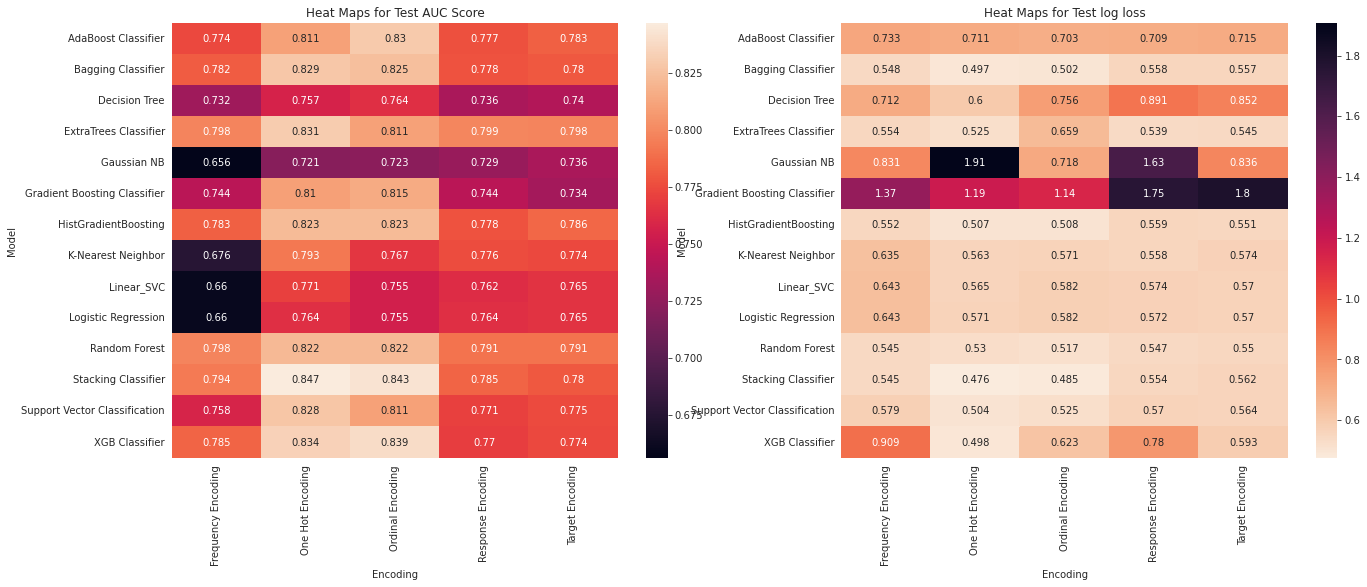

In [106]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
sns.heatmap(Result.pivot('Model','Encoding','Test_roc_auc_score'), annot = True, fmt='.3g', ax=ax[0])
sns.heatmap(Result.pivot('Model','Encoding','Test_log_loss'), annot = True, fmt='.3g', cmap=sns.cm.rocket_r, ax=ax[1])
ax[0].set_title('Heat Maps for Test AUC Score')
ax[1].set_title('Heat Maps for Test log loss')
plt.show()

__Observations:__
* Ordinal Encoding and One Hot Encoding perform best than other encoding techniques.
* Stacking Classifier, XGB Classifier, Support Vector Classification, HistGradientBoosting,  and Ensebles Classifier these models perform best than other models.
* Bagging, AdaBoost, Gradient Boosting, and ExtraTrees Classifier models are overfitting. They have a Training AUC Score is 1.
* The best-performed model is Stacking Classifier with Ordinal and One Hot Encoding so far.